In [1]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "./cifar-10-100n/")

import os
import torch
from PIL import Image as im
import pandas as pd
import numpy as np
from autogluon.vision import ImagePredictor, ImageDataset
import pickle
import datetime
from pathlib import Path
import cleanlab

from data.datasets import input_dataset
from cross_validation_autogluon import cross_val_predict_autogluon_image_dataset

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Read data

In [2]:
# get labels
noise_file = torch.load('./cifar-10-100n/data/CIFAR-10_human.pt')
clean_label = noise_file['clean_label']
worst_label = noise_file['worse_label']
aggre_label = noise_file['aggre_label']
random_label1 = noise_file['random_label1']
random_label2 = noise_file['random_label2']
random_label3 = noise_file['random_label3']

In [3]:
# get data
dataset = "cifar10"
noise_type = "aggre_label"
noise_path = "./cifar-10-100n/data/CIFAR-10_human.pt"
is_human = True

train_dataset, test_dataset, num_classes, num_training_samples = \
    input_dataset(dataset, noise_type, noise_path, is_human)

Loaded aggre_label from ./cifar-10-100n/data/CIFAR-10_human.pt.
The overall noise rate is 0.09009999999999996
noisy labels loaded from ./cifar-10-100n/data/CIFAR-10_human.pt
The noisy data ratio in each class is [0.10628 0.11018 0.10814 0.09242 0.08698 0.09926 0.09232 0.10006 0.10694
 0.09742]
over all noise rate is  0.0901


In [4]:
print(f"Accuracy of noisy labels vs true labels: {(aggre_label == clean_label).mean()}")

Accuracy of noisy labels vs true labels: 0.9099


In [5]:
# classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Manually inspect some images

In [6]:
label_errors_mask = aggre_label != clean_label

Datapoint index: 2599
  Noisy Label: 1, automobile
  True Label: 9, truck


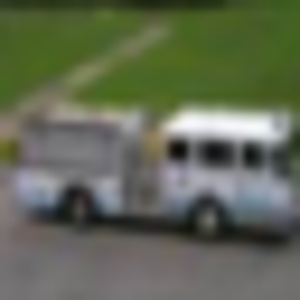

In [13]:
# check out some images
# idx = 0

# pick random image to inspect
idx = np.random.randint(0, train_dataset.train_data[label_errors_mask].shape[0])

X = train_dataset.train_data[label_errors_mask][idx]
noisy_label = np.array(train_dataset.train_noisy_labels)[label_errors_mask][idx]
true_label = np.array(train_dataset.train_labels)[label_errors_mask][idx]

print(f"Datapoint index: {idx}")
print(f"  Noisy Label: {noisy_label}, {classes[noisy_label]}")
print(f"  True Label: {true_label}, {classes[true_label]}")

newsize = (300, 300) # zoom in

im.fromarray(X).resize(newsize)

Datapoints to inspect further:

Datapoints (index) where the true label is wrong
  14023 (true label is airplane but looks like a bird)

## Save images to folder

AutoGluon image models require the data to be image files in a folder

We'll save the images as PNG files in a single folder and save their file paths in a list

In [14]:
%%time

# create folder
SAVE_PATH = "./cifar-10n-png/train/"
os.makedirs(SAVE_PATH)

# save images to folder

image_file_paths = [] # list of image file paths

for i, data in enumerate(train_dataset.train_data):
    
    # convert data to image object
    image = im.fromarray(data) 

    # path to image PNG file
    png_file = f"{SAVE_PATH}image_id_{i}.png"
    
    # print the number of images saved
    print(f"Images saved: {i + 1}", end="\r")
    
    # append file to list of file paths
    image_file_paths.append(png_file)
    
    # save image as PNG
    image.save(png_file)

CPU times: user 42 s, sys: 7.88 s, total: 49.9 s
Wall time: 1min 55s


## Create DataFrame to use as input for AutoGluon Image predictor

In [15]:
# Note: AutoGluon requires the column names to be "image" and "label"
df_train = pd.DataFrame({
    "image": image_file_paths,
    "label": train_dataset.train_noisy_labels, # noisy labels
    "true_label": train_dataset.train_labels # true labels
})

In [16]:
df_train.reset_index().to_csv("cifar-10n-dataset-noise-type-aggre.csv", index=False)

In [17]:
assert (clean_label == df_train.true_label.values).all()

# Optional: copy the images to a faster drive (e.g. M.2 SSD) which will speedup training

In [18]:
!cp -r ./cifar-10n-png/ /Data/cifar-10n-png/

In [ ]:
# !ls /Data/cifar-10n-png

In [19]:
# add prefix to file path if we moved it to another drive
prefix = "/Data/"
df_train["image"] = df_train.image.map(lambda f: str(Path(prefix + f)))
df_train.head()

,image,label,true_label
0,/Data/cifar-10n-png/train/image_id_0.png,6,6
1,/Data/cifar-10n-png/train/image_id_1.png,9,9
2,/Data/cifar-10n-png/train/image_id_2.png,9,9
3,/Data/cifar-10n-png/train/image_id_3.png,4,4
4,/Data/cifar-10n-png/train/image_id_4.png,1,1


In [20]:
!ls /Data

Massiv_CleanLab_Images		       cifar-10n-png  sandbox
Massiv_CleanLab_Images_Frame_Midpoint  cifar100_png   spoken_digits
andrew-ng-dcai-comp-2021-data-deduped  cifar10_png    v1.0.9.tar.gz


## Run cross-validation with AutoGluon

In [21]:
%%time

# generate cross-validated predicted probabilities for various models so we can use them for ensemble scoring methods
models = [
    "resnet18",
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224"
]

epochs = 100
holdout_frac = 0.2
n_splits = 5

# run cross-validation for each model
for model in models:
    
    print("----")
    print(f"Running cross-validation for model: {model}")

    MODEL_PARAMS = {
        "model": model,
        "epochs": epochs,
        "holdout_frac": holdout_frac
    }

    # results of cross-validation will be saved to pickle files for each model/fold
    _ = \
        cross_val_predict_autogluon_image_dataset(
            dataset=df_train, # train with NOISY LABELS
            out_folder=f"./cifar-10n-png_noise_type_aggre_cv_{model}/", # save results of cross-validation in pickle files for each fold
            n_splits=n_splits,
            model_params=MODEL_PARAMS
        )

modified configs(<old> != <new>): {
root.misc.seed       42 != 385
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet18
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/32c12fd8/.trial_0/config.yaml


----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 293.905752 samples/sec	accuracy=0.097500	lr=0.000100
Epoch[0] Batch [99]	Speed: 507.725364 samples/sec	accuracy=0.120625	lr=0.000100
Epoch[0] Batch [149]	Speed: 514.985906 samples/sec	accuracy=0.135833	lr=0.000100
Epoch[0] Batch [199]	Speed: 502.217202 samples/sec	accuracy=0.157812	lr=0.000100
Epoch[0] Batch [249]	Speed: 533.867247 samples/sec	accuracy=0.178750	lr=0.000100
Epoch[0] Batch [299]	Speed: 508.648490 samples/sec	accuracy=0.193958	lr=0.000100
Epoch[0] Batch [349]	Speed: 518.040512 samples/sec	accuracy=0.208214	lr=0.000100
Epoch[0] Batch [399]	Speed: 510.031581 samples/sec	accuracy=0.223906	lr=0.000100
Epoch[0] Batch [449]	Sp

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_0/_test_pred_probs_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_0/_test_pred_features_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_0/_test_labels_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_0/_test_image_files_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_0/_test_indices_split_0


modified configs(<old> != <new>): {
root.misc.seed       42 != 606
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet18
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/b8a7de04/.trial_0/config.yaml


----
Running Cross-Validation on Split: 1


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 284.274094 samples/sec	accuracy=0.095000	lr=0.000100
Epoch[0] Batch [99]	Speed: 512.389593 samples/sec	accuracy=0.121875	lr=0.000100
Epoch[0] Batch [149]	Speed: 502.424751 samples/sec	accuracy=0.142917	lr=0.000100
Epoch[0] Batch [199]	Speed: 480.182351 samples/sec	accuracy=0.162188	lr=0.000100
Epoch[0] Batch [249]	Speed: 494.545785 samples/sec	accuracy=0.181000	lr=0.000100
Epoch[0] Batch [299]	Speed: 492.995061 samples/sec	accuracy=0.198750	lr=0.000100
Epoch[0] Batch [349]	Speed: 508.624280 samples/sec	accuracy=0.215714	lr=0.000100
Epoch[0] Batch [399]	Speed: 498.793125 samples/sec	accuracy=0.230781	lr=0.000100
Epoch[0] Batch [449]	Speed: 520.001159 samples/sec	accuracy=0.244444	lr=0.000100
Epoch[0] Batch [499]	Speed: 494.941817 samples/sec	accuracy=0.258250	lr=0.0

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_1/_test_pred_probs_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_1/_test_pred_features_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_1/_test_labels_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_1/_test_image_files_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_1/_test_indices_split_1


modified configs(<old> != <new>): {
root.misc.seed       42 != 677
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet18
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/f97f1cc3/.trial_0/config.yaml


----
Running Cross-Validation on Split: 2


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 288.380200 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [99]	Speed: 554.241918 samples/sec	accuracy=0.150000	lr=0.000100
Epoch[0] Batch [149]	Speed: 535.355556 samples/sec	accuracy=0.179583	lr=0.000100
Epoch[0] Batch [199]	Speed: 517.248092 samples/sec	accuracy=0.201250	lr=0.000100
Epoch[0] Batch [249]	Speed: 543.958914 samples/sec	accuracy=0.218750	lr=0.000100
Epoch[0] Batch [299]	Speed: 492.860156 samples/sec	accuracy=0.234375	lr=0.000100
Epoch[0] Batch [349]	Speed: 491.470805 samples/sec	accuracy=0.250893	lr=0.000100
Epoch[0] Batch [399]	Speed: 498.402752 samples/sec	accuracy=0.264688	lr=0.000100
Epoch[0] Batch [449]	Speed: 514.688023 samples/sec	accuracy=0.277083	lr=0.000100
Epoch[0] Batch [499]	Speed: 527.706217 samples/sec	accuracy=0.289500	lr=0.0

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_2/_test_pred_probs_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_2/_test_pred_features_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_2/_test_labels_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_2/_test_image_files_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_2/_test_indices_split_2


modified configs(<old> != <new>): {
root.misc.seed       42 != 288
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet18
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/59d0bbe8/.trial_0/config.yaml


----
Running Cross-Validation on Split: 3


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 281.920574 samples/sec	accuracy=0.121250	lr=0.000100
Epoch[0] Batch [99]	Speed: 528.043711 samples/sec	accuracy=0.132500	lr=0.000100
Epoch[0] Batch [149]	Speed: 504.892401 samples/sec	accuracy=0.159583	lr=0.000100
Epoch[0] Batch [199]	Speed: 508.494094 samples/sec	accuracy=0.181875	lr=0.000100
Epoch[0] Batch [249]	Speed: 501.441390 samples/sec	accuracy=0.191500	lr=0.000100
Epoch[0] Batch [299]	Speed: 512.914208 samples/sec	accuracy=0.208125	lr=0.000100
Epoch[0] Batch [349]	Speed: 504.302720 samples/sec	accuracy=0.222321	lr=0.000100
Epoch[0] Batch [399]	Speed: 520.503613 samples/sec	accuracy=0.237969	lr=0.000100
Epoch[0] Batch [449]	Speed: 487.118075 samples/sec	accuracy=0.253056	lr=0.000100
Epoch[0] Batch [499]	Speed: 493.246096 samples/sec	accuracy=0.263125	lr=0.0

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_3/_test_pred_probs_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_3/_test_pred_features_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_3/_test_labels_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_3/_test_image_files_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_3/_test_indices_split_3


modified configs(<old> != <new>): {
root.misc.seed       42 != 194
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet18
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/b506261a/.trial_0/config.yaml


----
Running Cross-Validation on Split: 4


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 279.414268 samples/sec	accuracy=0.131250	lr=0.000100
Epoch[0] Batch [99]	Speed: 523.806180 samples/sec	accuracy=0.149375	lr=0.000100
Epoch[0] Batch [149]	Speed: 537.275545 samples/sec	accuracy=0.165000	lr=0.000100
Epoch[0] Batch [199]	Speed: 530.441452 samples/sec	accuracy=0.180000	lr=0.000100
Epoch[0] Batch [249]	Speed: 493.027513 samples/sec	accuracy=0.197000	lr=0.000100
Epoch[0] Batch [299]	Speed: 490.881949 samples/sec	accuracy=0.208542	lr=0.000100
Epoch[0] Batch [349]	Speed: 459.823416 samples/sec	accuracy=0.228214	lr=0.000100
Epoch[0] Batch [399]	Speed: 495.566953 samples/sec	accuracy=0.238125	lr=0.000100
Epoch[0] Batch [449]	Speed: 482.232850 samples/sec	accuracy=0.252639	lr=0.000100
Epoch[0] Batch [499]	Speed: 502.535740 samples/sec	accuracy=0.266875	lr=0.0

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_4/_test_pred_probs_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_4/_test_pred_features_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_4/_test_labels_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_4/_test_image_files_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet18/split_4/_test_indices_split_4


modified configs(<old> != <new>): {
root.misc.seed       42 != 434
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet50d
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/9b9ba22c/.trial_0/config.yaml


----
Running cross-validation for model: resnet50d
----
Running Cross-Validation on Split: 0


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth
Model resnet50d created, param count:                                         23547754
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 180.316364 samples/sec	accuracy=0.111250	lr=0.000100
Epoch[0] Batch [99]	Speed: 231.184638 samples/sec	accuracy=0.120625	lr=0.000100
Epoch[0] Batch [149]	Speed: 239.549675 samples/sec	accuracy=0.127083	lr=0.000100
Epoch[0] Batch [199]	Speed: 252.487288 samples/sec	accuracy=0.133125	lr=0.000100
Epoch[0] Batch [249]	Speed: 237.039348 samples/sec	accuracy=0.137750	lr=0.000100
Epoch[0] Batch [299]	Speed: 239.985381 samples/sec	accuracy=0.141458	lr=0.000100
Epoch[0] Batch [349]	Speed: 239.371794 samples/sec	accuracy=0.151071	lr=0.000100
Epoch[0] Batch [399]	Speed: 230.328839 samples/s

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_0/_test_pred_probs_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_0/_test_pred_features_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_0/_test_labels_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_0/_test_image_files_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_0/_test_indices_split_0


modified configs(<old> != <new>): {
root.misc.seed       42 != 466
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet50d
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}


----
Running Cross-Validation on Split: 1


Saved config to /dcai/src/experiments/cifar-10n-aggregate/55d76388/.trial_0/config.yaml
Model resnet50d created, param count:                                         23547754
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 139.450369 samples/sec	accuracy=0.096250	lr=0.000100
Epoch[0] Batch [99]	Speed: 223.283912 samples/sec	accuracy=0.104375	lr=0.000100
Epoch[0] Batch [149]	Speed: 225.034222 samples/sec	accuracy=0.109583	lr=0.000100
Epoch[0] Batch [199]	Speed: 225.024624 samples/sec	accuracy=0.120625	lr=0.000100
Epoch[0] Batch [249]	Speed: 224.219512 samples/sec	accuracy=0.126250	lr=0.000100
Epoch[0] Batch [299]	Speed: 230.518596 samples/sec	accuracy=0.131875	lr=0.000100
Epoch[0] Batch [349]	Speed: 229.928943 samples/sec	accuracy=0.136071	lr=0.000100
Epoch[0] Batch [399]	Speed: 223.744826 samples/sec	accuracy=0.140781	lr=0.000100
Epoch[0] Batch [449]	Speed: 229.114528 samples/sec	accuracy=0.14402

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_1/_test_pred_probs_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_1/_test_pred_features_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_1/_test_labels_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_1/_test_image_files_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_1/_test_indices_split_1


modified configs(<old> != <new>): {
root.misc.seed       42 != 196
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet50d
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}


----
Running Cross-Validation on Split: 2


Saved config to /dcai/src/experiments/cifar-10n-aggregate/087c4beb/.trial_0/config.yaml
Model resnet50d created, param count:                                         23547754
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 146.207548 samples/sec	accuracy=0.106250	lr=0.000100
Epoch[0] Batch [99]	Speed: 225.768816 samples/sec	accuracy=0.120625	lr=0.000100
Epoch[0] Batch [149]	Speed: 230.741156 samples/sec	accuracy=0.122083	lr=0.000100
Epoch[0] Batch [199]	Speed: 232.667032 samples/sec	accuracy=0.128125	lr=0.000100
Epoch[0] Batch [249]	Speed: 229.516805 samples/sec	accuracy=0.133750	lr=0.000100
Epoch[0] Batch [299]	Speed: 225.694664 samples/sec	accuracy=0.140625	lr=0.000100
Epoch[0] Batch [349]	Speed: 224.625880 samples/sec	accuracy=0.145357	lr=0.000100
Epoch[0] Batch [399]	Speed: 236.088980 samples/sec	accuracy=0.149375	lr=0.000100
Epoch[0] Batch [449]	Speed: 230.417792 samples/sec	accuracy=0.15694

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_2/_test_pred_probs_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_2/_test_pred_features_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_2/_test_labels_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_2/_test_image_files_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_2/_test_indices_split_2


modified configs(<old> != <new>): {
root.misc.seed       42 != 572
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet50d
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}


----
Running Cross-Validation on Split: 3


Saved config to /dcai/src/experiments/cifar-10n-aggregate/296decd2/.trial_0/config.yaml
Model resnet50d created, param count:                                         23547754
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 149.125586 samples/sec	accuracy=0.116250	lr=0.000100
Epoch[0] Batch [99]	Speed: 222.129313 samples/sec	accuracy=0.111250	lr=0.000100
Epoch[0] Batch [149]	Speed: 231.714012 samples/sec	accuracy=0.125000	lr=0.000100
Epoch[0] Batch [199]	Speed: 226.990189 samples/sec	accuracy=0.129375	lr=0.000100
Epoch[0] Batch [249]	Speed: 230.418473 samples/sec	accuracy=0.134250	lr=0.000100
Epoch[0] Batch [299]	Speed: 229.196079 samples/sec	accuracy=0.137917	lr=0.000100
Epoch[0] Batch [349]	Speed: 225.875673 samples/sec	accuracy=0.146429	lr=0.000100
Epoch[0] Batch [399]	Speed: 234.632972 samples/sec	accuracy=0.149219	lr=0.000100
Epoch[0] Batch [449]	Speed: 231.262235 samples/sec	accuracy=0.15402

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_3/_test_pred_probs_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_3/_test_pred_features_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_3/_test_labels_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_3/_test_image_files_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_3/_test_indices_split_3


modified configs(<old> != <new>): {
root.misc.seed       42 != 665
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != resnet50d
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/d5ca4874/.trial_0/config.yaml


----
Running Cross-Validation on Split: 4


Model resnet50d created, param count:                                         23547754
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 168.081994 samples/sec	accuracy=0.088750	lr=0.000100
Epoch[0] Batch [99]	Speed: 266.274310 samples/sec	accuracy=0.105625	lr=0.000100
Epoch[0] Batch [149]	Speed: 260.847669 samples/sec	accuracy=0.112917	lr=0.000100
Epoch[0] Batch [199]	Speed: 255.153473 samples/sec	accuracy=0.120000	lr=0.000100
Epoch[0] Batch [249]	Speed: 234.447573 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [299]	Speed: 256.684050 samples/sec	accuracy=0.130208	lr=0.000100
Epoch[0] Batch [349]	Speed: 269.427380 samples/sec	accuracy=0.135893	lr=0.000100
Epoch[0] Batch [399]	Speed: 266.311462 samples/sec	accuracy=0.141094	lr=0.000100
Epoch[0] Batch [449]	Speed: 271.586028 samples/sec	accuracy=0.148194	lr=0.000100
Epoch[0] Batch [499]	Speed: 256.596543 samples/sec	accuracy=0.154125	lr=0.

Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_4/_test_pred_probs_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_4/_test_pred_features_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_4/_test_labels_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_4/_test_image_files_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_resnet50d/split_4/_test_indices_split_4


modified configs(<old> != <new>): {
root.misc.seed       42 != 265
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != efficientnet_b1
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}


----
Running cross-validation for model: efficientnet_b1
----
Running Cross-Validation on Split: 0


Saved config to /dcai/src/experiments/cifar-10n-aggregate/545eeb85/.trial_0/config.yaml
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth
Model efficientnet_b1 created, param count:                                         6525994
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 139.691774 samples/sec	accuracy=0.107500	lr=0.000100
Epoch[0] Batch [99]	Speed: 157.407749 samples/sec	accuracy=0.111250	lr=0.000100
Epoch[0] Batch [149]	Speed: 190.421125 samples/sec	accuracy=0.116667	lr=0.000100
Epoch[0] Batch [199]	Speed: 181.968170 samples/sec	accuracy=0.128438	lr=0.000100
Epoch[0] Batch [249]	Speed: 179.354363 samples/sec	accuracy=0.139750	lr=0.000100
Epoch[0] Batch [299]	Speed: 171.362539 samples/sec	accuracy=0.143333	lr=0.000100
Epoch[0] Batch [349]	Speed: 157.

Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_0/_test_pred_probs_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_0/_test_pred_features_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_0/_test_labels_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_0/_test_image_files_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_0/_test_indices_split_0


modified configs(<old> != <new>): {
root.misc.seed       42 != 85
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != efficientnet_b1
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/beddca07/.trial_0/config.yaml


----
Running Cross-Validation on Split: 1


Model efficientnet_b1 created, param count:                                         6525994
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 141.961134 samples/sec	accuracy=0.112500	lr=0.000100
Epoch[0] Batch [99]	Speed: 176.681222 samples/sec	accuracy=0.113750	lr=0.000100
Epoch[0] Batch [149]	Speed: 163.281606 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [199]	Speed: 155.947532 samples/sec	accuracy=0.131250	lr=0.000100
Epoch[0] Batch [249]	Speed: 176.215111 samples/sec	accuracy=0.137250	lr=0.000100
Epoch[0] Batch [299]	Speed: 175.837206 samples/sec	accuracy=0.148333	lr=0.000100
Epoch[0] Batch [349]	Speed: 168.962212 samples/sec	accuracy=0.155000	lr=0.000100
Epoch[0] Batch [399]	Speed: 182.063083 samples/sec	accuracy=0.162969	lr=0.000100
Epoch[0] Batch [449]	Speed: 165.366450 samples/sec	accuracy=0.174444	lr=0.000100
Epoch[0] Batch [499]	Speed: 174.051223 samples/sec	accuracy=0.183000	

Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_1/_test_pred_probs_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_1/_test_pred_features_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_1/_test_labels_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_1/_test_image_files_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_1/_test_indices_split_1


modified configs(<old> != <new>): {
root.misc.seed       42 != 394
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != efficientnet_b1
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/dd28a4e4/.trial_0/config.yaml


----
Running Cross-Validation on Split: 2


Model efficientnet_b1 created, param count:                                         6525994
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 135.088068 samples/sec	accuracy=0.085000	lr=0.000100
Epoch[0] Batch [99]	Speed: 185.774077 samples/sec	accuracy=0.094375	lr=0.000100
Epoch[0] Batch [149]	Speed: 184.825480 samples/sec	accuracy=0.107083	lr=0.000100
Epoch[0] Batch [199]	Speed: 189.778548 samples/sec	accuracy=0.111250	lr=0.000100
Epoch[0] Batch [249]	Speed: 184.751965 samples/sec	accuracy=0.125000	lr=0.000100
Epoch[0] Batch [299]	Speed: 172.264782 samples/sec	accuracy=0.138333	lr=0.000100
Epoch[0] Batch [349]	Speed: 197.200638 samples/sec	accuracy=0.150179	lr=0.000100
Epoch[0] Batch [399]	Speed: 193.762234 samples/sec	accuracy=0.160000	lr=0.000100
Epoch[0] Batch [449]	Speed: 192.567973 samples/sec	accuracy=0.170556	lr=0.000100
Epoch[0] Batch [499]	Speed: 181.761094 samples/sec	accuracy=0.177250	

Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_2/_test_pred_probs_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_2/_test_pred_features_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_2/_test_labels_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_2/_test_image_files_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_2/_test_indices_split_2


modified configs(<old> != <new>): {
root.misc.seed       42 != 188
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != efficientnet_b1
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/82a9a489/.trial_0/config.yaml


----
Running Cross-Validation on Split: 3


Model efficientnet_b1 created, param count:                                         6525994
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 142.918851 samples/sec	accuracy=0.098750	lr=0.000100
Epoch[0] Batch [99]	Speed: 190.040228 samples/sec	accuracy=0.112500	lr=0.000100
Epoch[0] Batch [149]	Speed: 176.281164 samples/sec	accuracy=0.115417	lr=0.000100
Epoch[0] Batch [199]	Speed: 185.757776 samples/sec	accuracy=0.125312	lr=0.000100
Epoch[0] Batch [249]	Speed: 174.116856 samples/sec	accuracy=0.133250	lr=0.000100
Epoch[0] Batch [299]	Speed: 174.499726 samples/sec	accuracy=0.142500	lr=0.000100
Epoch[0] Batch [349]	Speed: 175.402685 samples/sec	accuracy=0.150536	lr=0.000100
Epoch[0] Batch [399]	Speed: 176.040445 samples/sec	accuracy=0.158281	lr=0.000100
Epoch[0] Batch [449]	Speed: 179.076498 samples/sec	accuracy=0.165972	lr=0.000100
Epoch[0] Batch [499]	Speed: 167.310392 samples/sec	accuracy=0.173000	

Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_3/_test_pred_probs_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_3/_test_pred_features_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_3/_test_labels_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_3/_test_image_files_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_3/_test_indices_split_3


modified configs(<old> != <new>): {
root.misc.seed       42 != 90
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != efficientnet_b1
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/b408ceec/.trial_0/config.yaml


----
Running Cross-Validation on Split: 4


Model efficientnet_b1 created, param count:                                         6525994
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 136.244728 samples/sec	accuracy=0.106250	lr=0.000100
Epoch[0] Batch [99]	Speed: 166.625369 samples/sec	accuracy=0.105000	lr=0.000100
Epoch[0] Batch [149]	Speed: 178.465425 samples/sec	accuracy=0.108333	lr=0.000100
Epoch[0] Batch [199]	Speed: 174.926305 samples/sec	accuracy=0.117813	lr=0.000100
Epoch[0] Batch [249]	Speed: 172.264597 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [299]	Speed: 170.243932 samples/sec	accuracy=0.129792	lr=0.000100
Epoch[0] Batch [349]	Speed: 190.782092 samples/sec	accuracy=0.137857	lr=0.000100
Epoch[0] Batch [399]	Speed: 169.474515 samples/sec	accuracy=0.141875	lr=0.000100
Epoch[0] Batch [449]	Speed: 153.555817 samples/sec	accuracy=0.150556	lr=0.000100
Epoch[0] Batch [499]	Speed: 157.062816 samples/sec	accuracy=0.159250	

Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_4/_test_pred_probs_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_4/_test_pred_features_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_4/_test_labels_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_4/_test_image_files_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/split_4/_test_indices_split_4


modified configs(<old> != <new>): {
root.misc.seed       42 != 701
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != twins_pcpvt_base
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/27d23a50/.trial_0/config.yaml


----
Running cross-validation for model: twins_pcpvt_base
----
Running Cross-Validation on Split: 0


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vt3p-weights/twins_pcpvt_base-e5ecb09b.pth" to /root/.cache/torch/hub/checkpoints/twins_pcpvt_base-e5ecb09b.pth
Model twins_pcpvt_base created, param count:                                         43320586
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 93.728461 samples/sec	accuracy=0.217500	lr=0.000100
Epoch[0] Batch [99]	Speed: 108.155431 samples/sec	accuracy=0.253750	lr=0.000100
Epoch[0] Batch [149]	Speed: 113.635483 samples/sec	accuracy=0.312917	lr=0.000100
Epoch[0] Batch [199]	Speed: 103.827428 samples/sec	accuracy=0.373125	lr=0.000100
Epoch[0] Batch [249]	Speed: 105.783040 samples/sec	accuracy=0.419250	lr=0.000100
Epoch[0] Batch [299]	Speed: 97.975687 samples/sec	accuracy=0.456667	lr=0.000100
Epoch[0] Batch [349]	Speed: 96.275030 samples/sec	accuracy=0.484464	lr=0.000100
Epoch[0] Batch [399]	Speed: 100.1

Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_0/_test_pred_probs_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_0/_test_pred_features_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_0/_test_labels_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_0/_test_image_files_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_0/_test_indices_split_0


modified configs(<old> != <new>): {
root.misc.seed       42 != 518
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != twins_pcpvt_base
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/bcf42661/.trial_0/config.yaml


----
Running Cross-Validation on Split: 1


Model twins_pcpvt_base created, param count:                                         43320586
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 92.012656 samples/sec	accuracy=0.087500	lr=0.000100
Epoch[0] Batch [99]	Speed: 93.937177 samples/sec	accuracy=0.153125	lr=0.000100
Epoch[0] Batch [149]	Speed: 98.940217 samples/sec	accuracy=0.218750	lr=0.000100
Epoch[0] Batch [199]	Speed: 97.504936 samples/sec	accuracy=0.275625	lr=0.000100
Epoch[0] Batch [249]	Speed: 104.710606 samples/sec	accuracy=0.321500	lr=0.000100
Epoch[0] Batch [299]	Speed: 101.239793 samples/sec	accuracy=0.372083	lr=0.000100
Epoch[0] Batch [349]	Speed: 101.746488 samples/sec	accuracy=0.408036	lr=0.000100
Epoch[0] Batch [399]	Speed: 101.256929 samples/sec	accuracy=0.440312	lr=0.000100
Epoch[0] Batch [449]	Speed: 97.506831 samples/sec	accuracy=0.469167	lr=0.000100
Epoch[0] Batch [499]	Speed: 101.901365 samples/sec	accuracy=0.489750	lr=

Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_1/_test_pred_probs_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_1/_test_pred_features_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_1/_test_labels_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_1/_test_image_files_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_1/_test_indices_split_1


modified configs(<old> != <new>): {
root.misc.seed       42 != 137
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != twins_pcpvt_base
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/46671298/.trial_0/config.yaml


----
Running Cross-Validation on Split: 2


Model twins_pcpvt_base created, param count:                                         43320586
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 96.019879 samples/sec	accuracy=0.146250	lr=0.000100
Epoch[0] Batch [99]	Speed: 110.601116 samples/sec	accuracy=0.191250	lr=0.000100
Epoch[0] Batch [149]	Speed: 101.109990 samples/sec	accuracy=0.242500	lr=0.000100
Epoch[0] Batch [199]	Speed: 108.400088 samples/sec	accuracy=0.303438	lr=0.000100
Epoch[0] Batch [249]	Speed: 108.166648 samples/sec	accuracy=0.356250	lr=0.000100
Epoch[0] Batch [299]	Speed: 101.570921 samples/sec	accuracy=0.398125	lr=0.000100
Epoch[0] Batch [349]	Speed: 107.596592 samples/sec	accuracy=0.434107	lr=0.000100
Epoch[0] Batch [399]	Speed: 101.984856 samples/sec	accuracy=0.465469	lr=0.000100
Epoch[0] Batch [449]	Speed: 99.038605 samples/sec	accuracy=0.491250	lr=0.000100
Epoch[0] Batch [499]	Speed: 103.493402 samples/sec	accuracy=0.511250	

Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_2/_test_pred_probs_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_2/_test_pred_features_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_2/_test_labels_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_2/_test_image_files_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_2/_test_indices_split_2


modified configs(<old> != <new>): {
root.misc.seed       42 != 766
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != twins_pcpvt_base
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/481537a4/.trial_0/config.yaml


----
Running Cross-Validation on Split: 3


Model twins_pcpvt_base created, param count:                                         43320586
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 89.068275 samples/sec	accuracy=0.128750	lr=0.000100
Epoch[0] Batch [99]	Speed: 109.179920 samples/sec	accuracy=0.226250	lr=0.000100
Epoch[0] Batch [149]	Speed: 108.343907 samples/sec	accuracy=0.296667	lr=0.000100
Epoch[0] Batch [199]	Speed: 100.005490 samples/sec	accuracy=0.357812	lr=0.000100
Epoch[0] Batch [249]	Speed: 101.166609 samples/sec	accuracy=0.403250	lr=0.000100
Epoch[0] Batch [299]	Speed: 107.382378 samples/sec	accuracy=0.444167	lr=0.000100
Epoch[0] Batch [349]	Speed: 112.626582 samples/sec	accuracy=0.473571	lr=0.000100
Epoch[0] Batch [399]	Speed: 108.812520 samples/sec	accuracy=0.497969	lr=0.000100
Epoch[0] Batch [449]	Speed: 113.056481 samples/sec	accuracy=0.522083	lr=0.000100
Epoch[0] Batch [499]	Speed: 109.680226 samples/sec	accuracy=0.539625

Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_3/_test_pred_probs_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_3/_test_pred_features_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_3/_test_labels_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_3/_test_image_files_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_3/_test_indices_split_3


modified configs(<old> != <new>): {
root.misc.seed       42 != 266
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != twins_pcpvt_base
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/3df68357/.trial_0/config.yaml


----
Running Cross-Validation on Split: 4


Model twins_pcpvt_base created, param count:                                         43320586
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 93.242537 samples/sec	accuracy=0.160000	lr=0.000100
Epoch[0] Batch [99]	Speed: 106.026938 samples/sec	accuracy=0.212500	lr=0.000100
Epoch[0] Batch [149]	Speed: 112.901854 samples/sec	accuracy=0.290417	lr=0.000100
Epoch[0] Batch [199]	Speed: 109.855917 samples/sec	accuracy=0.344375	lr=0.000100
Epoch[0] Batch [249]	Speed: 113.397836 samples/sec	accuracy=0.390250	lr=0.000100
Epoch[0] Batch [299]	Speed: 107.570463 samples/sec	accuracy=0.426875	lr=0.000100
Epoch[0] Batch [349]	Speed: 114.347686 samples/sec	accuracy=0.460893	lr=0.000100
Epoch[0] Batch [399]	Speed: 113.858510 samples/sec	accuracy=0.487187	lr=0.000100
Epoch[0] Batch [449]	Speed: 114.821552 samples/sec	accuracy=0.510556	lr=0.000100
Epoch[0] Batch [499]	Speed: 107.479578 samples/sec	accuracy=0.532625

Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_4/_test_pred_probs_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_4/_test_pred_features_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_4/_test_labels_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_4/_test_image_files_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/split_4/_test_indices_split_4


modified configs(<old> != <new>): {
root.misc.seed       42 != 338
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != swin_base_patch4_window7_224
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/7bc85167/.trial_0/config.yaml


----
Running cross-validation for model: swin_base_patch4_window7_224
----
Running Cross-Validation on Split: 0


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth
Model swin_base_patch4_window7_224 created, param count:                                         86753474
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 87.996664 samples/sec	accuracy=0.111250	lr=0.000100
Epoch[0] Batch [99]	Speed: 101.865087 samples/sec	accuracy=0.180625	lr=0.000100
Epoch[0] Batch [149]	Speed: 101.183147 samples/sec	accuracy=0.232500	lr=0.000100
Epoch[0] Batch [199]	Speed: 101.240004 samples/sec	accuracy=0.287813	lr=0.000100
Epoch[0] Batch [249]	Speed: 100.959111 samples/sec	accuracy=0.341750	lr=0.000100
Epoch[0] Batch [299]	Speed: 101.028247 samples/sec	accuracy=0.388542	lr=0.000100
Epoch[0] Batch [349]	Speed: 101.072303 samples/sec	accuracy=0.433929	lr=0.000100
Epoch[0] Batch 

Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_0/_test_pred_probs_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_0/_test_pred_features_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_0/_test_labels_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_0/_test_image_files_split_0
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_0/_test_indices_split_0


modified configs(<old> != <new>): {
root.misc.seed       42 != 623
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != swin_base_patch4_window7_224
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/f382dcb2/.trial_0/config.yaml


----
Running Cross-Validation on Split: 1


Model swin_base_patch4_window7_224 created, param count:                                         86753474
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 85.291214 samples/sec	accuracy=0.100000	lr=0.000100
Epoch[0] Batch [99]	Speed: 101.416022 samples/sec	accuracy=0.151875	lr=0.000100
Epoch[0] Batch [149]	Speed: 101.565995 samples/sec	accuracy=0.222083	lr=0.000100
Epoch[0] Batch [199]	Speed: 101.861469 samples/sec	accuracy=0.293750	lr=0.000100
Epoch[0] Batch [249]	Speed: 101.252804 samples/sec	accuracy=0.348750	lr=0.000100
Epoch[0] Batch [299]	Speed: 101.241256 samples/sec	accuracy=0.396250	lr=0.000100
Epoch[0] Batch [349]	Speed: 101.490979 samples/sec	accuracy=0.435714	lr=0.000100
Epoch[0] Batch [399]	Speed: 101.362372 samples/sec	accuracy=0.470156	lr=0.000100
Epoch[0] Batch [449]	Speed: 101.914717 samples/sec	accuracy=0.497778	lr=0.000100
Epoch[0] Batch [499]	Speed: 101.602543 samples/sec	accur

Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_1/_test_pred_probs_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_1/_test_pred_features_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_1/_test_labels_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_1/_test_image_files_split_1
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_1/_test_indices_split_1


modified configs(<old> != <new>): {
root.misc.seed       42 != 566
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != swin_base_patch4_window7_224
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/1de8d10b/.trial_0/config.yaml


----
Running Cross-Validation on Split: 2


Model swin_base_patch4_window7_224 created, param count:                                         86753474
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 86.195740 samples/sec	accuracy=0.065000	lr=0.000100
Epoch[0] Batch [99]	Speed: 101.146153 samples/sec	accuracy=0.137500	lr=0.000100
Epoch[0] Batch [149]	Speed: 101.182451 samples/sec	accuracy=0.195417	lr=0.000100
Epoch[0] Batch [199]	Speed: 101.586376 samples/sec	accuracy=0.255625	lr=0.000100
Epoch[0] Batch [249]	Speed: 102.133558 samples/sec	accuracy=0.319500	lr=0.000100
Epoch[0] Batch [299]	Speed: 101.713703 samples/sec	accuracy=0.370208	lr=0.000100
Epoch[0] Batch [349]	Speed: 101.189271 samples/sec	accuracy=0.414107	lr=0.000100
Epoch[0] Batch [399]	Speed: 101.584601 samples/sec	accuracy=0.450469	lr=0.000100
Epoch[0] Batch [449]	Speed: 101.829434 samples/sec	accuracy=0.483194	lr=0.000100
Epoch[0] Batch [499]	Speed: 101.043267 samples/sec	accur

Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_2/_test_pred_probs_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_2/_test_pred_features_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_2/_test_labels_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_2/_test_image_files_split_2
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_2/_test_indices_split_2


modified configs(<old> != <new>): {
root.misc.seed       42 != 116
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != swin_base_patch4_window7_224
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/44673436/.trial_0/config.yaml


----
Running Cross-Validation on Split: 3


Model swin_base_patch4_window7_224 created, param count:                                         86753474
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 85.404404 samples/sec	accuracy=0.217500	lr=0.000100
Epoch[0] Batch [99]	Speed: 101.374150 samples/sec	accuracy=0.280000	lr=0.000100
Epoch[0] Batch [149]	Speed: 101.910548 samples/sec	accuracy=0.350417	lr=0.000100
Epoch[0] Batch [199]	Speed: 101.612525 samples/sec	accuracy=0.405625	lr=0.000100
Epoch[0] Batch [249]	Speed: 101.254952 samples/sec	accuracy=0.460000	lr=0.000100
Epoch[0] Batch [299]	Speed: 101.346229 samples/sec	accuracy=0.506667	lr=0.000100
Epoch[0] Batch [349]	Speed: 101.572750 samples/sec	accuracy=0.539286	lr=0.000100
Epoch[0] Batch [399]	Speed: 100.811566 samples/sec	accuracy=0.568750	lr=0.000100
Epoch[0] Batch [449]	Speed: 100.438452 samples/sec	accuracy=0.593472	lr=0.000100
Epoch[0] Batch [499]	Speed: 99.752023 samples/sec	accura

Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_3/_test_pred_probs_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_3/_test_pred_features_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_3/_test_labels_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_3/_test_image_files_split_3
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_3/_test_indices_split_3


modified configs(<old> != <new>): {
root.misc.seed       42 != 341
root.misc.num_workers 4 != 16
root.img_cls.model   resnet101 != swin_base_patch4_window7_224
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_max_value 1.0 != inf
}
Saved config to /dcai/src/experiments/cifar-10n-aggregate/9e189a06/.trial_0/config.yaml


----
Running Cross-Validation on Split: 4


Model swin_base_patch4_window7_224 created, param count:                                         86753474
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 85.742968 samples/sec	accuracy=0.131250	lr=0.000100
Epoch[0] Batch [99]	Speed: 99.995375 samples/sec	accuracy=0.197500	lr=0.000100
Epoch[0] Batch [149]	Speed: 100.160023 samples/sec	accuracy=0.285417	lr=0.000100
Epoch[0] Batch [199]	Speed: 100.375150 samples/sec	accuracy=0.360625	lr=0.000100
Epoch[0] Batch [249]	Speed: 99.957728 samples/sec	accuracy=0.420250	lr=0.000100
Epoch[0] Batch [299]	Speed: 101.093516 samples/sec	accuracy=0.463958	lr=0.000100
Epoch[0] Batch [349]	Speed: 101.275076 samples/sec	accuracy=0.495357	lr=0.000100
Epoch[0] Batch [399]	Speed: 101.305185 samples/sec	accuracy=0.523125	lr=0.000100
Epoch[0] Batch [449]	Speed: 100.300371 samples/sec	accuracy=0.549028	lr=0.000100
Epoch[0] Batch [499]	Speed: 98.316139 samples/sec	accuracy

Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_4/_test_pred_probs_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_4/_test_pred_features_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_4/_test_labels_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_4/_test_image_files_split_4
Saving ./cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/split_4/_test_indices_split_4
CPU times: user 1d 16h 51min 54s, sys: 2h 19min 52s, total: 1d 19h 11min 47s
Wall time: 1d 19h 52min 6s
